In [9]:
import numpy
import matplotlib.pyplot as plot
import torch
torch.set_default_dtype(torch.float64)

In [10]:
import numpy



'''
Naive and straightforward implementation of the inside/outside point mesh test
'''

def is_inside_naive(triangles, X):
	# Compute triangle vertices and their norms relative to X
	M = triangles - X
	M_norm = numpy.sqrt(numpy.sum(M ** 2, axis = 2))

	# Accumulate generalized winding number per triangle
	winding_number = 0.
	for (A, B, C), (a, b, c) in zip(M, M_norm):
		winding_number += numpy.arctan2(numpy.linalg.det(numpy.array([A, B, C])), (a * b * c) + c * numpy.dot(A, B) + a * numpy.dot(B, C) + b * numpy.dot(C, A))

	# Job done
	return winding_number >= 2. * numpy.pi




def is_inside(triangles, X):
	ret = torch.zeros(X.shape[0], dtype = X.dtype, device=X.device)
	
	for U, V, W in triangles:	
		A, B, C = U - X, V - X, W - X
		omega = torch.det(torch.stack([A, B, C], dim=1))
		
		a, b, c = torch.norm(A, dim=1), torch.norm(B, dim=1), torch.norm(C, dim=1)
		k = a * b * c
		k += c * torch.sum(A * B, dim=1)
		k += a * torch.sum(B * C, dim=1)
		k += b * torch.sum(C * A, dim=1)

		ret += torch.atan2(omega, k)
	
	return ret >= 2 * torch.pi


In [11]:


import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch



# Create a default mesh, for example, a sphere
mesh = o3d.geometry.TriangleMesh.create_sphere()

# Convert mesh to numpy arrays
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

triangles = vertices[triangles]

# # Compute uniform distribution within the axis-aligned bound box for the mesh
min_corner = numpy.amin(numpy.amin(triangles, axis = 0), axis = 0)
max_corner = numpy.amax(numpy.amax(triangles, axis = 0), axis = 0)


triangles = torch.from_numpy(triangles).double()
min_corner = triangles.view(-1, 3).min(dim=0).values
max_corner = triangles.view(-1, 3).max(dim=0).values

# print(min_corner.shape)
min_corner -= 0.05 * (max_corner - min_corner)
max_corner += 0.05 * (max_corner - min_corner)
P = (max_corner - min_corner) * torch.rand((8198, 3)) + min_corner

# # Filter out points which are not inside the mesh
# triangles = torch.from_numpy(triangles).double()
# P = P[is_inside(triangles, P, triangles, P)]
mask = is_inside(triangles.cuda(), P.cuda())

# assert (mask_numpy == mask.numpy()).all()
print(P.max())
P = P[mask]



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f15295df280>>
Traceback (most recent call last):
  File "/home/druhe/rail1/src/cnf/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


tensor(1.1050)


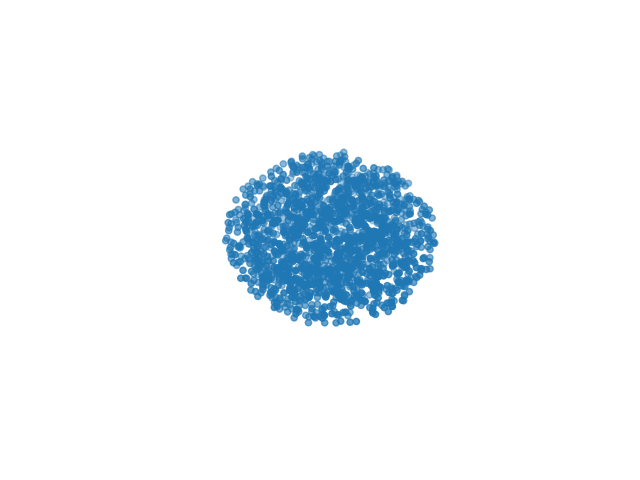

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = P[:,0], P[:,1], P[:,2]
ax.scatter(x, y, z)


# Remove the axes
ax.set_axis_off()

plt.show()

In [ ]:
# load /home/druhe/datasets/ModelNet40/airplane/train/airplane_0001.off

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    
    n_verts, n_faces, _ = tuple([int(s) for s in file.readline().strip().split(' ')])
    vertices = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    
    return vertices, faces

with open('/home/druhe/datasets/ModelNet40/airplane/train/airplane_0001.off', 'r') as f:
    vertices, faces = read_off(f)


In [ ]:
vertices = torch.tensor(vertices)
faces = torch.tensor(faces)

vertices = vertices - vertices.mean(dim=0)
vertices = vertices / vertices.norm(dim=1).max()


triangles = vertices[faces]

In [ ]:
min_corner = triangles.view(-1, 3).min(dim=0).values
max_corner = triangles.view(-1, 3).max(dim=0).values

# print(min_corner.shape)
min_corner -= 0.05 * (max_corner - min_corner)
max_corner += 0.05 * (max_corner - min_corner)
P = (max_corner - min_corner) * torch.rand((8198, 3)) + min_corner



# # Filter out points which are not inside the mesh
# triangles = torch.from_numpy(triangles).double()
# P = P[is_inside(triangles, P, triangles, P)]
mask = is_inside(triangles.cuda(), P.cuda())


In [ ]:
mask.any()

tensor(False, device='cuda:0')

In [ ]:
P

tensor([], size=(0, 3))

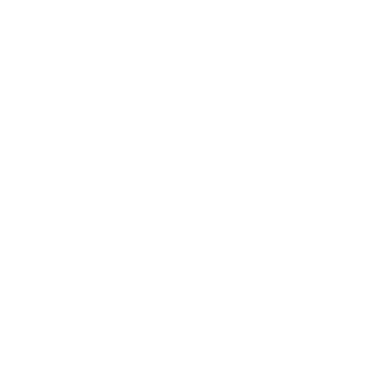

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = P[:,0], P[:,1], P[:,2]
ax.scatter(x, y, z)


# Remove the axes
ax.set_axis_off()

plt.show()

In [ ]:
import trimesh

In [ ]:
mesh = trimesh.load('/home/druhe/datasets/ModelNet40/airplane/train/airplane_0001.off')

In [ ]:
def calculate_normals(vertices, faces):
    normals = np.zeros(vertices.shape, dtype=np.float64)
    for face in faces:
        v1 = vertices[face[1]] - vertices[face[0]]
        v2 = vertices[face[2]] - vertices[face[0]]
        normal = np.cross(v1, v2)
        normal = normal / np.linalg.norm(normal)
        for vertex in face:
            normals[vertex] += normal
    for i in range(len(normals)):
        normals[i] = normals[i] / np.linalg.norm(normals[i])
    return normals

normals = calculate_normals(mesh.vertices, mesh.faces)


/tmp/ipykernel_2074050/1753648945.py:7: RuntimeWarning: invalid value encountered in divide
  normal = normal / np.linalg.norm(normal)
/tmp/ipykernel_2074050/1753648945.py:11: RuntimeWarning: invalid value encountered in divide
  normals[i] = normals[i] / np.linalg.norm(normals[i])


In [ ]:
normals.shape

(27817, 3)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt 
import numpy as np

def plot_mesh(vertices, faces):
    # Extract x, y, and z coordinates
    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]

    # Plotting the original mesh
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mesh_plot = ax.plot_trisurf(x, y, faces, Z=z)

    # Creating and plotting the shadow
    shadow_z = np.full_like(z, -1.5)  # Set all z-coordinates of the shadow to -1.5
    shadow_plot = ax.plot_trisurf(x, y, faces, Z=shadow_z, shade=False, color='black', edgecolor='none', alpha=0.5)

    # Removing the axes
    ax.axis('off')

    plt.show()


In [13]:
import trimesh
import torch
import numpy as np

In [14]:
mesh = trimesh.load('/home/druhe/manf/ManifoldPlus/build/output.obj', process=False)

In [15]:
mesh.is_watertight

True

In [ ]:
plot_mesh(mesh.vertices, mesh.faces)

NameError: name 'plot_mesh' is not defined

In [29]:
mesh.vertices /= np.linalg.norm(mesh.vertices, axis=1).max()
mesh.vertices -= mesh.vertices.mean(axis=0)

# triangles = torch.tensor(mesh.vertices[mesh.faces])

In [31]:
from tqdm import trange

# triangles = torch.tensor(triangles)

# print(triangles.shape)
# raise

# min_corner = triangles.view(-1, 3).min(dim=0).values
# max_corner = triangles.view(-1, 3).max(dim=0).values

# # print(min_corner.shape)
# min_corner -= 0.05 * (max_corner - min_corner)
# max_corner += 0.05 * (max_corner - min_corner)

# P = torch.rand((100000, 3)) * 2 - 1



# # Filter out points which are not inside the mesh
# triangles = torch.from_numpy(triangles).double()
# P = P[is_inside(triangles, P, triangles, P)]
# mask = is_inside(triangles.cuda(), P.cuda())
# for i in trange(100000):
#     P = (max_corner - min_corner) * torch.rand((1, 3)) + min_corner
#     mesh.contains(P)


# mask = mesh.contains(P)

# P = P[mask]
# print(P.shape)

In [58]:
samples = 2 ** 19
batch_size = 64
iterations = samples // batch_size

for i in trange(iterations):
    points = trimesh.sample.volume_mesh(mesh, batch_size)

  0%|          | 6/8192 [00:11<4:19:45,  1.90s/it]


KeyboardInterrupt: 

In [ ]:
points

array([[-0.68233819,  0.18849314, -0.08421899],
       [ 0.21655278, -0.28092165,  0.40959364],
       [-0.33982301, -0.02811543, -0.01638108],
       ...,
       [ 0.82484107, -0.01980171,  0.0744421 ],
       [ 0.04615624,  0.04932397, -0.32662472],
       [-0.06276015,  0.0848743 ,  0.17180841]])

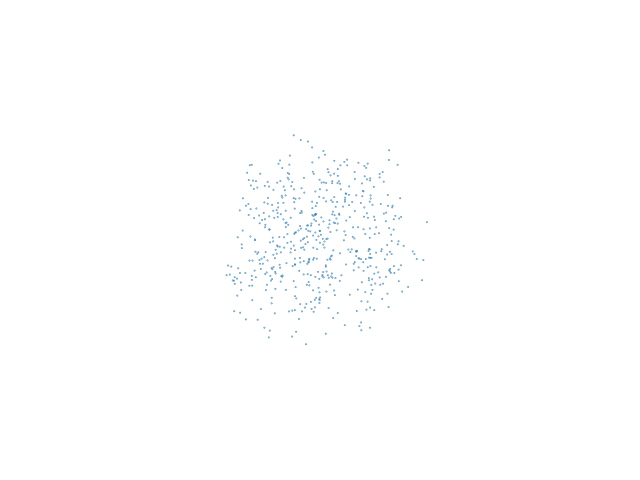

In [ ]:
%matplotlib widget
def plot_point_cloud(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = points[:,0], points[:,1], points[:,2]
    ax.scatter(x, y, z, s=0.1, alpha=1)

    # Remove the axes
    ax.set_axis_off()

    plt.show()

plot_point_cloud(points)